# Midterm Assignment - Part 3
by, K. Thach

Part 3 of the midterm assignment includes creating, Model B. Model B is a binary classifier used to classify cats vs. dogs. The model training utilizes the the [Dogs vs. Cats Training dataset on Kaggle](https://www.kaggle.com/c/dogs-vs-cats). This model is trained on the SRGAN generated images.

* **Model B**: Train a binary classifier using transfer learning
    * Input images are size 128 x 128
    * This model must have a 70% / 30% training split
* Compare Model Performances
    * Model A (standard augmented images, size 128 x 128)
    * Model B (SRGAN images, size 128 x 128)
    


**References:**

1. Will Cukierski. (2013). Dogs vs. Cats. Kaggle. https://kaggle.com/competitions/dogs-vs-cats
2. Ahmad Javed. (2021). Using Transformer Learning to Classify Cats & Dogs. https://www.kaggle.com/code/ahmadjaved097/using-transfer-learning-to-classify-cats-dogs

## Data Organization and Initialization Steps

This section will import all neccesary libraries and specify the organization of the data structures. The training is performed remotely using Google Colab resources. The Dog vs. Cat training dataset is stored in the users Google drive and split into `train`,`validation` and `test` folders.

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7703147880178217335
xla_global_id: -1
]
Mounted at /content/drive


In [2]:
# General path were all resources are located.

DirPath = '/content/drive/MyDrive/AI/'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os

from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Convolution2D, MaxPool2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import BinaryCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, ResNet50
from keras import applications

from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import requests
import tensorflow_datasets as tfds
import tqdm
import os
import shutil
import re
import cv2
import time
import logging

In [5]:
train_dataset_path = DirPath + 'Assignment-1/Datasets2/train'
val_dataset_path = DirPath + 'Assignment-1/Datasets2/validation'
test_dataset_path = DirPath + 'Assignment-1/Datasets2/test'

In [6]:
BATCH_SIZE = 34
IMG_WIDTH = 32
IMG_HEIGHT = 32
IMG_CHANNELS = 3
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

print(f"Batch Size: {BATCH_SIZE}")
print(f"Image Shape: {IMG_SHAPE}")

Batch Size: 34
Image Shape: (32, 32, 3)


In [7]:
# Reading in Train, Validation, and Test DatafFrames
fold_num = 2
path1 = DirPath + 'Assignment-1/Datasets2/_archive/df_train_2.csv'
df_train = pd.read_csv(path1)
df_train.sample(frac = 1, random_state = fold_num)

path3 = DirPath + 'Assignment-1/Datasets2/df_val.csv'
print(path3)
df_val = pd.read_csv(path3)
df_val.sample(frac = 1, random_state = fold_num)

/content/drive/MyDrive/AI/Assignment-1/Datasets2/df_val.csv


Class       Filename
1310   cat   cat.8591.jpg
2461   cat   cat.1944.jpg
1580   dog  dog.11650.jpg
1938   cat   cat.6749.jpg
1124   cat   cat.5286.jpg
...    ...            ...
674    dog   dog.3640.jpg
2408   cat   cat.3433.jpg
1099   cat  cat.11454.jpg
2347   dog   dog.8657.jpg
1608   dog  dog.12161.jpg

[2500 rows x 2 columns]

In [8]:
path2 = DirPath + 'Assignment-1/Datasets2/df_test.csv'
print(path2)
df_test = pd.read_csv(path2)
df_test.sample(frac = 1, random_state = fold_num)

/content/drive/MyDrive/AI/Assignment-1/Datasets2/df_test.csv


Class       Filename
1310   cat  cat.10489.jpg
2461   dog   dog.7241.jpg
1580   cat   cat.7591.jpg
1938   dog  dog.10252.jpg
1124   dog   dog.2146.jpg
...    ...            ...
674    dog   dog.3890.jpg
2408   cat     cat.76.jpg
1099   cat   cat.6986.jpg
2347   dog   dog.5380.jpg
1608   cat   cat.6858.jpg

[2500 rows x 2 columns]

In [10]:
# Create an ImageDataGenerator for each dataset.
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range = 0.2,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  vertical_flip = True,
                                  fill_mode = 'nearest',
                                  validation_split = 0.1)

train_generator = train_datagen.flow_from_dataframe(dataframe = df_train,
                                                directory = DirPath + 'Assignment-1/Datasets2/train/',
                                                target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'binary',
                                                x_col = 'Filename',
                                                y_col = 'Class',
                                                color_mode = 'rgb',
                                                shuffle = True)


Found 20000 validated image filenames belonging to 2 classes.


In [11]:
validation_generator = train_datagen.flow_from_dataframe(dataframe = df_val,
                                                directory = DirPath + 'Assignment-1/Datasets2/validation/',
                                                target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'binary',
                                                x_col = 'Filename',
                                                y_col = 'Class',
                                                color_mode = 'rgb',
                                                shuffle = True)

Found 2500 validated image filenames belonging to 2 classes.


In [12]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range = 0.2,
    rotation_range = 90,
    fill_mode = 'constant')

test_generator = test_datagen.flow_from_dataframe(dataframe = df_test,
                                                  directory = DirPath + 'Assignment-1/Datasets2/test/',
                                                  target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size = BATCH_SIZE,
                                                  class_mode = 'binary',
                                                  x_col = 'Filename',
                                                  y_col = 'Class',
                                                  color_mode = 'rgb',
                                                  shuffle = True)

Found 2500 validated image filenames belonging to 2 classes.


In [13]:
# Determining the labels available.

labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")


Label Mappings for classes present in the training and validation datasets

0 : cat
1 : dog


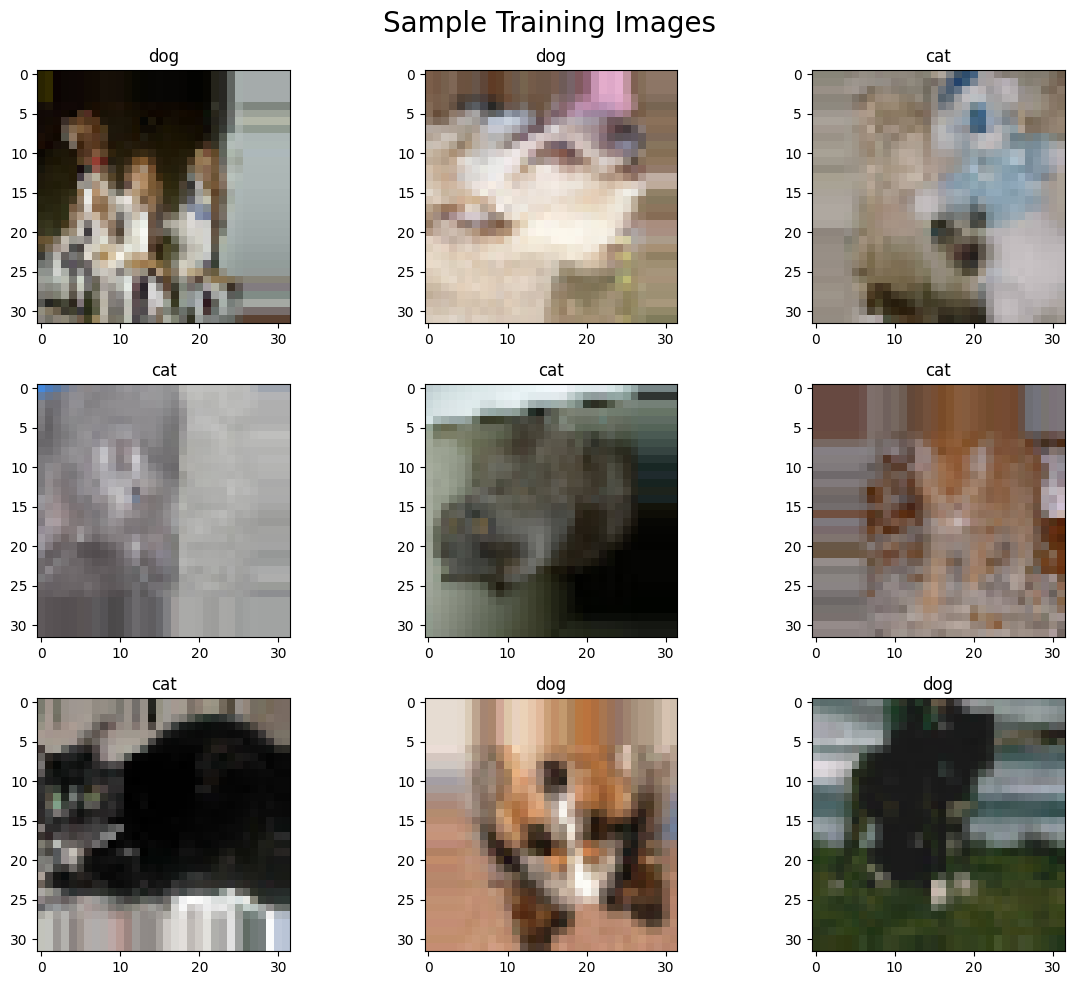

In [70]:
# Output from image data generator
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (12, 10))
idx = 0
plt.suptitle("Sample Training Images", fontsize = 20)
for i in range(3):
    for j in range(3):
        label = labels[train_generator[0][1][idx]]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("on")
        idx += 1

plt.tight_layout()
plt.show()

In [20]:
@tf.function
def build_data(data):
  #cropped=tf.dtypes.cast(tf.image.random_crop(data['image'] / 255,(128,128,3)),tf.float32)
  #cropped = tf.image.resize(data['image'], (128, 128)) / 255.0
  resized = tf.image.resize(data['image'], (128, 128))
  resized_normalized = resized / 255.0  # Normalize the resized image

  # Cast the normalized image to float16
  resized_normalized_float32 = tf.dtypes.cast(resized_normalized, tf.float32)
  lr=tf.image.resize(resized_normalized_float32,(32,32))
  #lr=tf.image.resize(lr,(128,128),method=tf.image.ResizeMethod.BICUBIC)
  return (lr,resized_normalized_float32)

In [28]:
def bicubic_interpolate(image,shape):
  img_resized=cv2.resize(image,shape, interpolation=cv2.INTER_CUBIC)
  return img_resized

In [19]:
def residual_block_gen(ch=64,k_s=3,st=1):
  model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
  ])
  return model

def Upsample_block(x, ch=256, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st), padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x

input_lr=tf.keras.layers.Input(shape=(None,None,3))
input_conv=tf.keras.layers.Conv2D(64,9,padding='same')(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

SRRes=input_conv
for x in range(5):
  res_output=residual_block_gen()(SRRes)
  SRRes=tf.keras.layers.Add()([SRRes,res_output])

SRRes=tf.keras.layers.Conv2D(64,9,padding='same')(SRRes)
SRRes=tf.keras.layers.BatchNormalization()(SRRes)

SRRes=tf.keras.layers.Add()([SRRes,input_conv])

SRRes=Upsample_block(SRRes)
SRRes=Upsample_block(SRRes)

output_sr=tf.keras.layers.Conv2D(3,9,activation='tanh',padding='same')(SRRes)

SRResnet=tf.keras.models.Model(input_lr,output_sr)

In [21]:
SRResnet=tf.keras.models.load_model('/content/drive/MyDrive/AI/midterm/SRGAN-Training/SRResNet-generator-150.h5',compile=False)


In [44]:
im = train_generator[0][0][idx]
lr=bicubic_interpolate(im,(im.shape[1]//4,im.shape[0]//4))

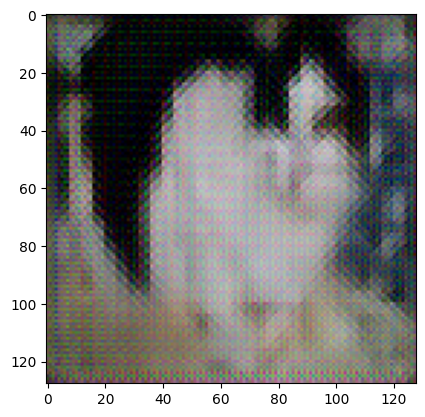

In [66]:
im = train_generator[3][0]
pred=SRResnet(im)
plt.imshow(pred[1])

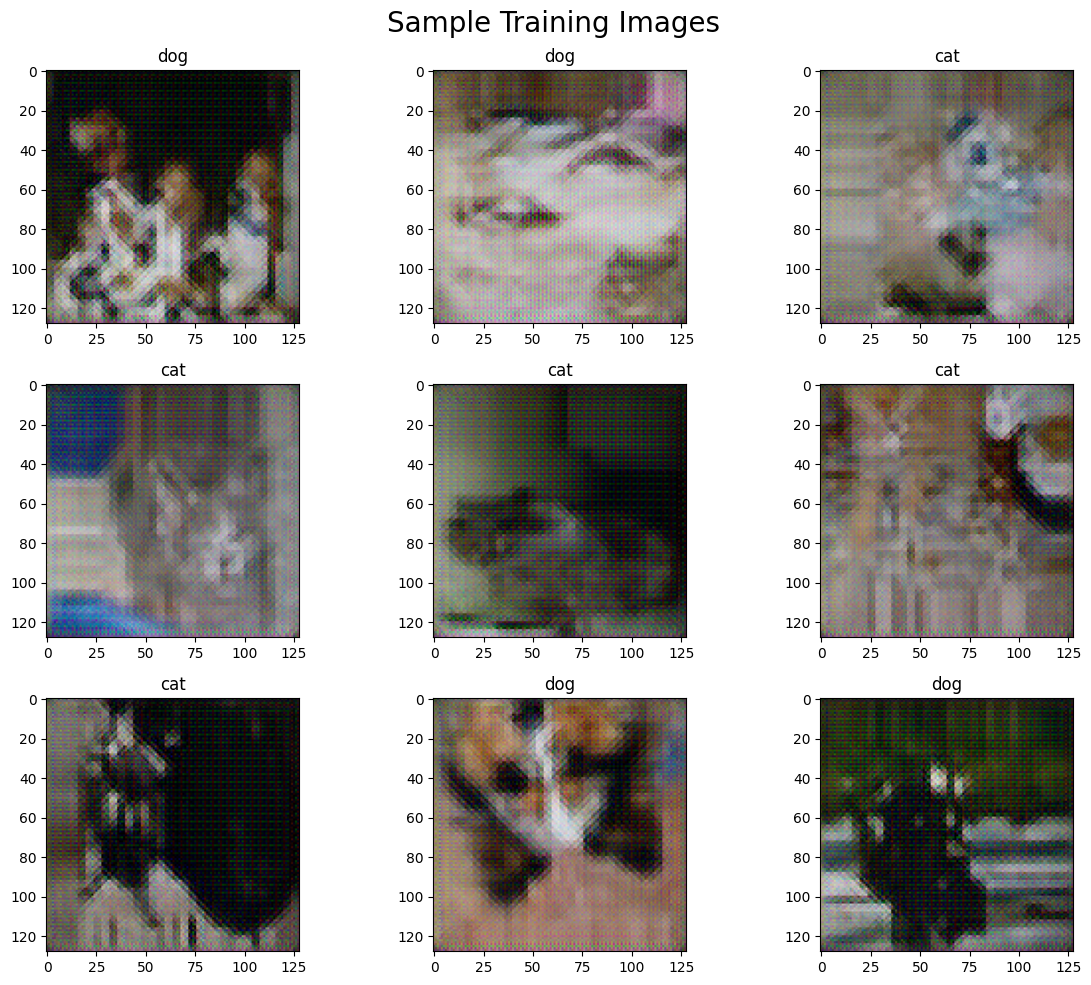

In [69]:
# Output from image data generator
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (12, 10))
idx = 0
plt.suptitle("Sample Training Images", fontsize = 20)
im = train_generator[0][0]
pred=SRResnet(im)

for i in range(3):
    for j in range(3):
        label = labels[train_generator[0][1][idx]]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(pred[idx])
        ax[i, j].axis("on")
        idx += 1

plt.tight_layout()
plt.show()

In [75]:
def apply_srgan_to_generator(data_generator, srgan_model):
    for data in data_generator:
        input_images, _ = data
        output_images = SRResnet(input_images)
        yield output_images, _

# Assuming train_generator and srgan_model are defined

# Applying the SRGAN model to the images in the data generator
train_generator_with_srgan = apply_srgan_to_generator(train_generator, SRResnet)


def apply_srgan_to_generator(data_generator, srgan_model):
    for data in data_generator:
        input_images, _ = data
        output_images = SRResnet(input_images)
        yield output_images, input_images

# Assuming 'test_generator' is your original test generator and 'srgan_model' is your SRGAN model

# Creating a new training generator by passing the original test generator through the SRGAN model
new_train_generator = apply_srgan_to_generator(train_generator, SRResnet)

TypeError: ignored

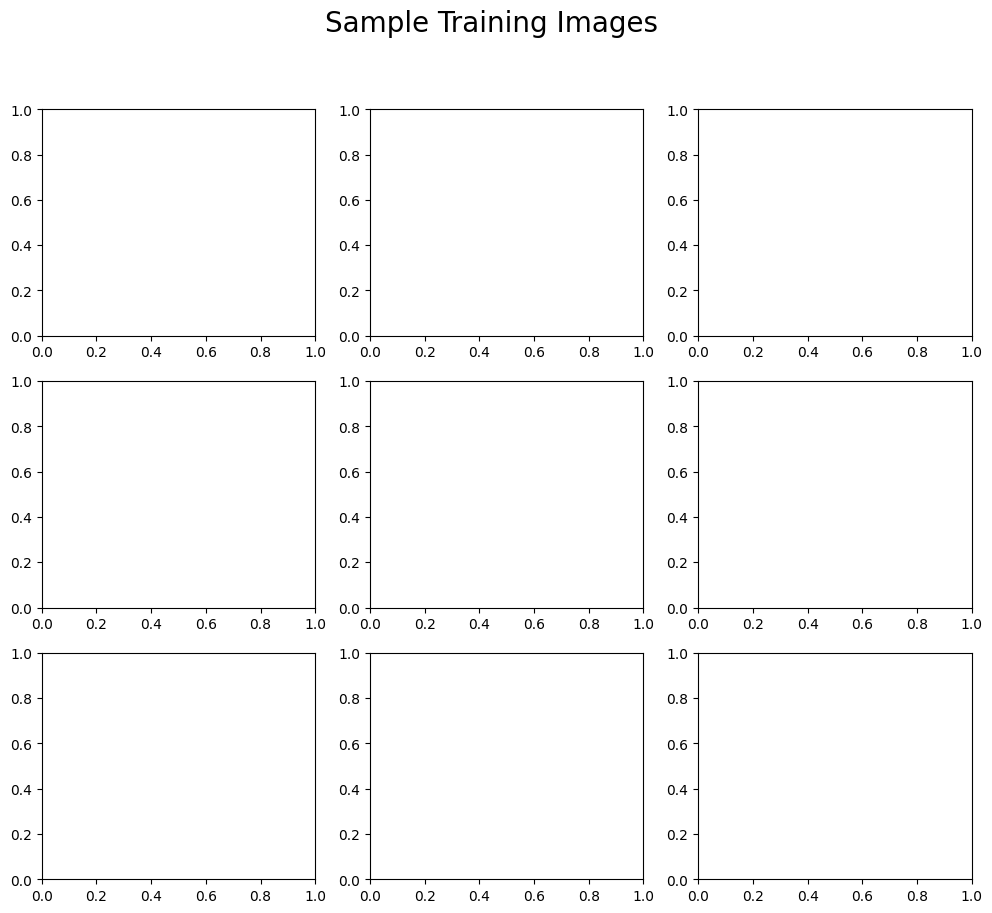

In [76]:
# Output from image data generator
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (12, 10))
idx = 0
plt.suptitle("Sample Training Images", fontsize = 20)
for i in range(3):
    for j in range(3):
        label = labels[train_generator_with_srgan[0][1][idx]]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator_with_srgan[0][0][idx][:, :, :])
        ax[i, j].axis("on")
        idx += 1

plt.tight_layout()
plt.show()

## Create Model

The pre-trained VGG16 model is used as the base model for this classifier. The

In [ ]:
## Training a pretrained model using transfer learning

base_model = VGG16(input_shape = IMG_SHAPE, include_top=False, weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Freeze top layer of the base model
base_model.trainable = False
# add classification layers
inputs = Input(shape = IMG_SHAPE)
x = base_model(inputs, training = False)
#My lines
x = Dense(8192, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 dense (Dense)               (None, 4, 4, 8192)        4202496   
                                                                 
 dropout (Dropout)           (None, 4, 4, 8192)        0         
                                                                 
 dense_1 (Dense)             (None, 4, 4, 4096)        33558528  
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 4096)        0         
                                                                 
 global_average_pooling2d (  (None, 4096)              0     

In [ ]:
## Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                            factor=np.sqrt(0.1),
                             patience=5)

# Defining the Optimizer
base_learning_rate = 0.00001
optimizer = Adam(learning_rate=base_learning_rate)

# Compile the Model
model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
# Sample first iteration:

loss_0, accuracy_0 = model.evaluate(test_generator)

print(f"Initial Loss: {loss_0:.2f}")
print(f"Initial Accuracy: {accuracy_0: .2f}")

74/74 [==============================] - 669s 9s/step - loss: 0.6932 - accuracy: 0.5052
Initial Loss: 0.69
Initial Accuracy:  0.51


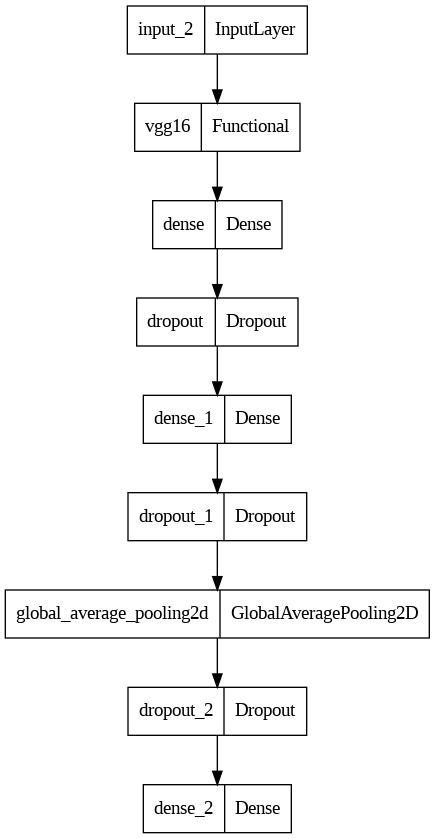

In [ ]:
# Model CheckPointer
from datetime import datetime
freq = 20
# Folder setup
init_time = datetime.now()
current_time = init_time.strftime('%Y%m%d_%H%M%S')
name_dir = DirPath + '/midterm/trained_models_' + current_time
os.mkdir(name_dir)

# Callbacks1: ModelCheckpointer
model_file_format = name_dir + '/model_' + str(fold_num) + '_model.{epoch:04d}.hdf5'
check = ModelCheckpoint(model_file_format, save_freq = freq, verbose = 1)

# Callbacks2: TensorBoard
tensor_check = name_dir + '/logs/' + current_time + '_train_testsplit'
tensor_board = TensorBoard(tensor_check)

# Callbacks3: EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

figure_name = name_dir + '/model_output.png'
tf.keras.utils.plot_model(model,figure_name)

In [ ]:
from tensorflow.keras.callbacks import Callback

class SaveModelAfterEachEpoch(Callback):
    def __init__(self, name_dir, foldx_num):
        super(SaveModelAfterEachEpoch, self).__init__()
        self.name_dir = name_dir
        self.fold_num = fold_num

    def on_epoch_end(self, epoch, logs=None):
        model_name = f"{self.name_dir}/model_2_model.{epoch + 1:04d}.hdf5"
        self.model.save(model_name)
        print(f"Epoch {epoch + 1}: Model saved to {model_name}")


class SaveModelAfterFirstEpoch(Callback):
  def on_epoch_end(self,epoch,logs=None):
    if epoch ==0:
      self.model.save(name_dir  +"/model_after_first_epoch.hdf5")

In [ ]:
# Specify the name_dir and fold_num for the callback
# name_dir defined above
foldx_num = 1
#save_first_epoch_callback = SaveModelAfterFirstEpoch()
# Create an instance of the SaveModelAfterEachEpoch callback
save_callback = SaveModelAfterEachEpoch(name_dir, fold_num)

In [ ]:
# Training the Model

initial_epochs = 15

history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=validation_generator,
                    callbacks=[check, tensor_board,early_stop,save_callback])


early_stop_name = name_dir + '/fold_num_' + str(fold_num) + 'early_stop_model.hdf5'
model.save_weights(early_stop_name)

Epoch 1/15
 19/589 [..............................] - ETA: 1:28:56 - loss: 0.7001 - accuracy: 0.5093
Epoch 1: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_001653/model_2_model.0001.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 39/589 [>.............................] - ETA: 1:26:10 - loss: 0.6950 - accuracy: 0.5143
Epoch 1: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_001653/model_2_model.0001.hdf5
 59/589 [==>...........................] - ETA: 1:22:41 - loss: 0.6885 - accuracy: 0.5309
Epoch 1: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_001653/model_2_model.0001.hdf5
 79/589 [===>..........................] - ETA: 1:18:50 - loss: 0.6843 - accuracy: 0.5458
Epoch 1: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_001653/model_2_model.0001.hdf5
 99/589 [====>.........................] - ETA: 1:16:38 - loss: 0.6800 - accuracy: 0.5585
Epoch 1: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_001653/model_2_model.0001.hdf5
119/589 [=====>........................] - ETA: 1:13:45 - loss: 0.6729 - accuracy: 0.5774
Epoch 1: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_001653

KeyboardInterrupt: ignored

In [ ]:
last_epoch = 0
# Load the previously saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/AI/midterm/trained_models_20231105_001653/model_2_model.0001.hdf5')

foldx_num = 1
# Create an instance of the SaveModelAfterEachEpoch callback
save_callback = SaveModelAfterEachEpoch(name_dir, foldx_num)

# Specify the new epoch range
num_epochs = 15

history = model.fit(train_generator,
                    initial_epoch=last_epoch + 1,
                    epochs=num_epochs + last_epoch,
                    validation_data=validation_generator,
                    callbacks=[check, tensor_board,early_stop,save_callback,reduce_lr])


early_stop_name = name_dir + '/fold_num_' + str(fold_num) + '/early_stop_model.hdf5'
model.save_weights(early_stop_name)


# Continue training the m

Epoch 2/15
 19/589 [..............................] - ETA: 1:29:46 - loss: 0.5011 - accuracy: 0.7430
Epoch 2: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_133623/model_2_model.0002.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 39/589 [>.............................] - ETA: 1:27:07 - loss: 0.4832 - accuracy: 0.7647
Epoch 2: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_133623/model_2_model.0002.hdf5
 59/589 [==>...........................] - ETA: 1:25:05 - loss: 0.4880 - accuracy: 0.7652
Epoch 2: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_133623/model_2_model.0002.hdf5
 79/589 [===>..........................] - ETA: 1:21:45 - loss: 0.4891 - accuracy: 0.7647
Epoch 2: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_133623/model_2_model.0002.hdf5
 99/589 [====>.........................] - ETA: 1:18:49 - loss: 0.4870 - accuracy: 0.7686
Epoch 2: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_133623/model_2_model.0002.hdf5
119/589 [=====>........................] - ETA: 1:16:34 - loss: 0.4865 - accuracy: 0.7682
Epoch 2: saving model to /content/drive/MyDrive/AI//midterm/trained_models_20231105_133623

FileNotFoundError: ignored

In [ ]:
# Plotting the training and validation accuracy, loss and learning rate
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

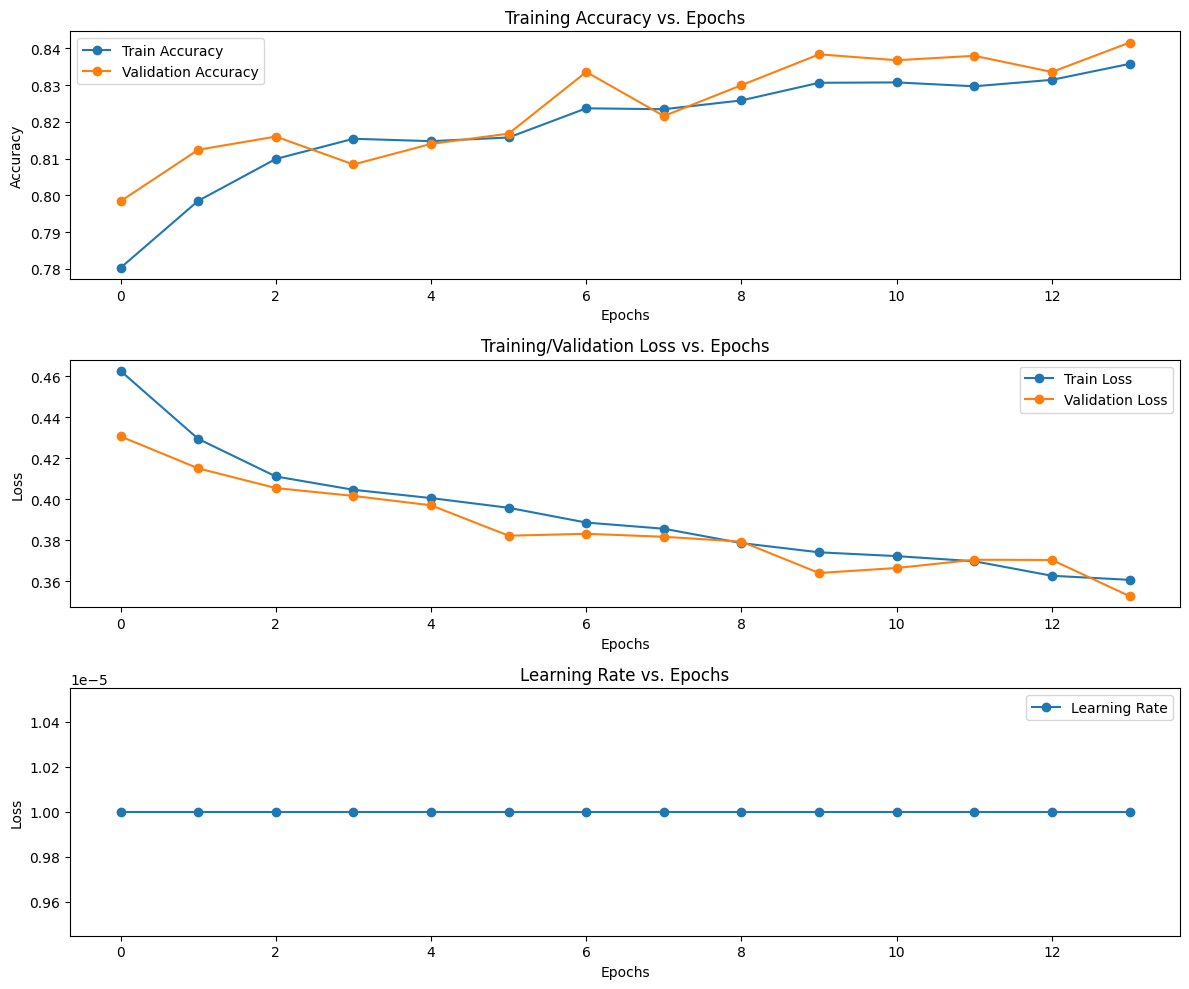

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:
predictions = model.predict(test_generator)

74/74 [==============================] - 695s 10s/step


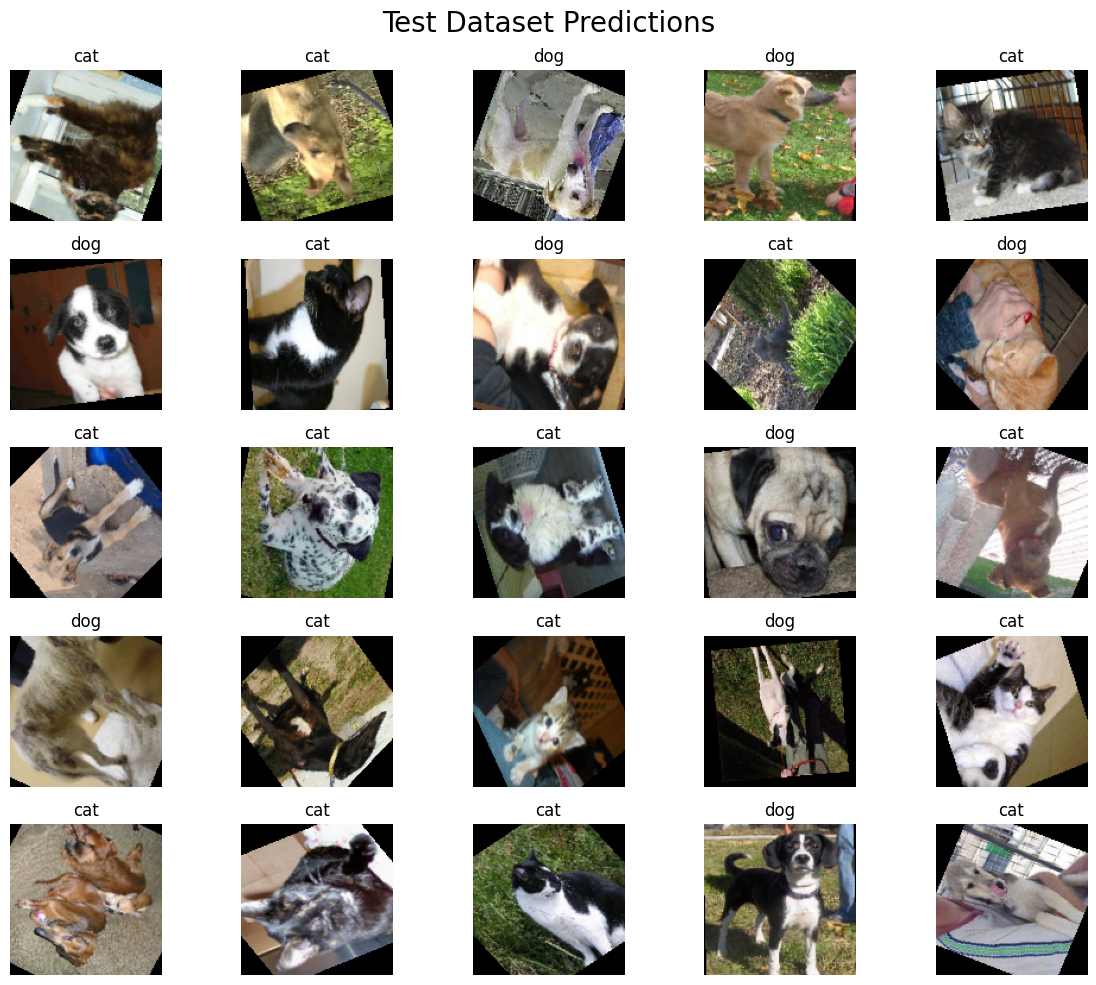

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(12, 10))
idx = 0
plt.suptitle('Test Dataset Predictions', fontsize=20)

for i in range(5):
    for j in range(5):
        predicted_label = labels[np.round(predictions.T[0][idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=BATCH_SIZE)

print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

74/74 [==============================] - 18s 240ms/step - loss: 0.4848 - accuracy: 0.7616
Test Loss:     0.4848026931285858
Test Accuracy: 0.7616000175476074


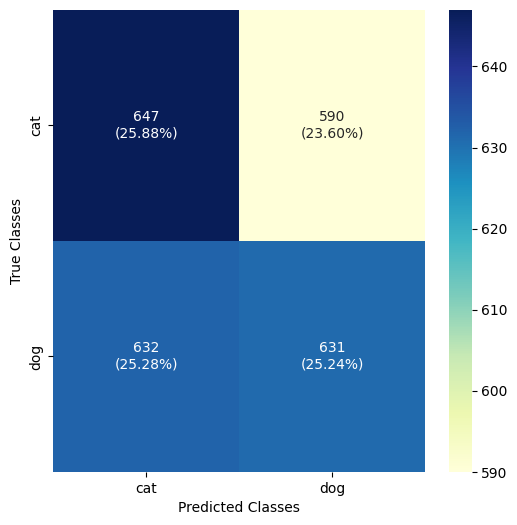

In [ ]:
y_pred = np.round(predictions)
y_pred = y_pred.T[0]          # to make the shape of y_true and y_pred same
y_true = test_generator.classes
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(2, 2)

plt.figure(figsize = (6, 6))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)

plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

         cat       0.51      0.52      0.51      1237
         dog       0.52      0.50      0.51      1263

    accuracy                           0.51      2500
   macro avg       0.51      0.51      0.51      2500
weighted avg       0.51      0.51      0.51      2500



## Training SRGAN

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import requests
import tensorflow_datasets as tfds
import tqdm
import os
import shutil
import re
import cv2
import time
import logging

In [ ]:
class TqdmLoggingHandler(logging.Handler):
    def __init__(self, level=logging.NOTSET):
        super().__init__(level)

    def emit(self, record):
        try:
            msg = self.format(record)
            tqdm.tqdm.write(msg)
            self.flush()
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            self.handleError(record)
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
log.addHandler(TqdmLoggingHandler())

/content/drive/MyDrive/AI/Assignment-1/Datasets2/train/cat.11282.jpg


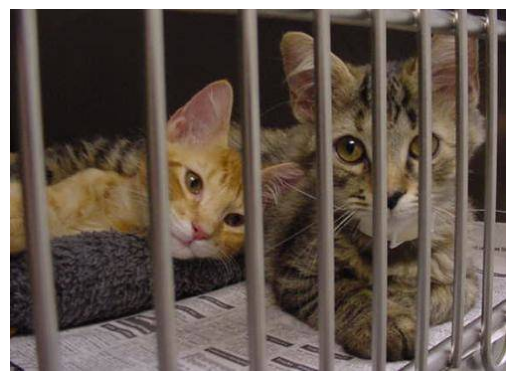

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_path = DirPath + 'Assignment-1/Datasets2/train/' + df_train.Filename[0]
print(DirPath + 'Assignment-1/Datasets2/train/' + df_train.Filename[0])
img = mpimg.imread(image_path)
# Display the first image from the batch
plt.imshow(img)

plt.axis('off')
plt.show()

In [ ]:
def bicubic_interpolate(image,shape):
  img_resized=cv2.resize(image,shape, interpolation=cv2.INTER_CUBIC)
  return img_resized

In [ ]:

def build_data(data):
  #cropped=tf.dtypes.cast(tf.image.random_crop(data['image'] / 255,(128,128,3)),tf.float32)
  box = (100, 100, 227, 227)  # Example values, adjust according to your requirements

    # Crop the image
  cropped = data.crop(box)
  lr=tf.image.resize(cropped,(32,32))
  #lr=tf.image.resize(lr,(128,128),method=tf.image.ResizeMethod.BICUBIC)
  return (lr,cropped)

Found 20000 validated image filenames belonging to 2 classes.


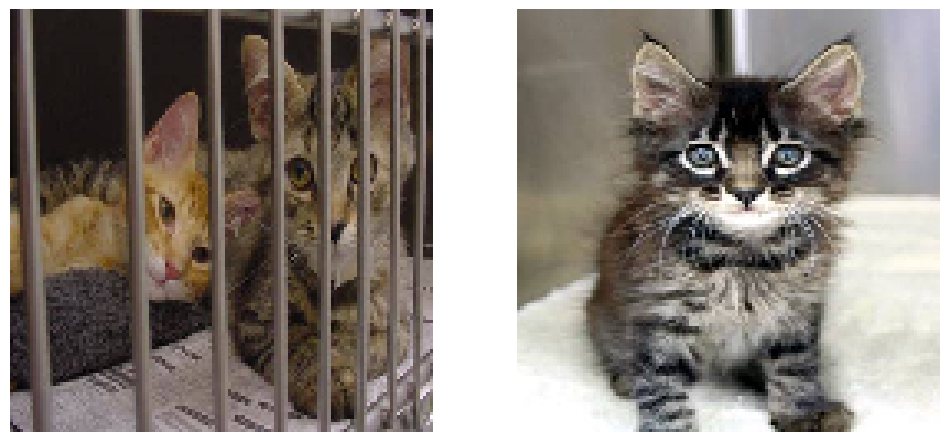

1


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define the image data generator without augmentations
train_datagen = ImageDataGenerator(rescale=1.0/255)

# Specify the directory containing the images
train_directory = DirPath + 'Assignment-1/Datasets2/train/'  # Replace with the actual path to the training directory

# Generate batches of data from the dataframe without augmentations
train_generator = train_datagen.flow_from_dataframe(
    dataframe= df_train,
    directory= train_directory,  # Replace with the actual path to the image directory
    x_col='Filename',
    y_col='Class',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Visualize 2 images from the batch
images, labels = next(train_generator)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')
plt.show()
print(i)



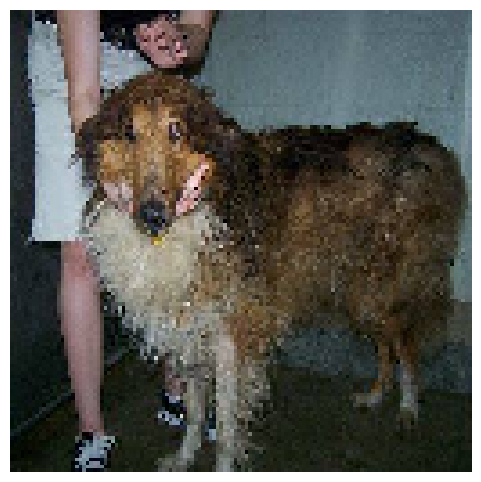

In [ ]:
images, labels = next(train_generator)
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(images[0])
ax.axis('off')
plt.show()

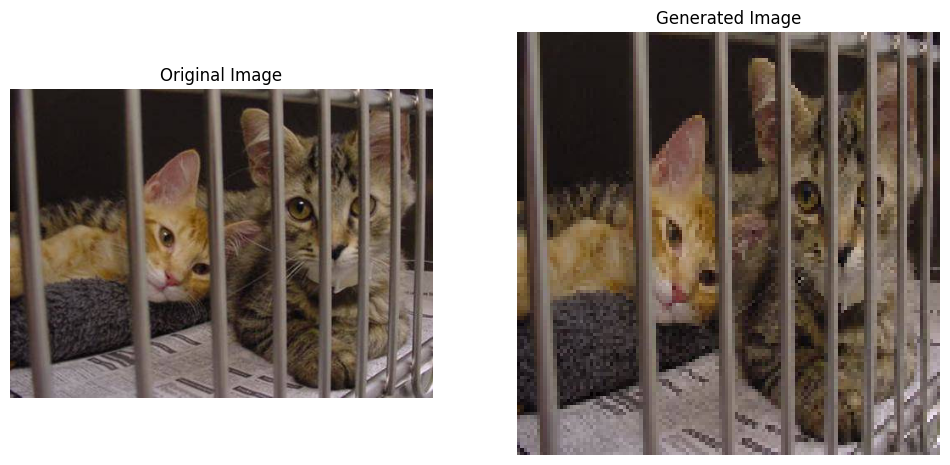

In [ ]:
from PIL import Image

# Get the file paths and labels from the batch
file_paths = train_generator.filepaths
labels = train_generator.labels

# Load and display the original and generated images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
original_image = Image.open(file_paths[0])
generated_image = train_generator[0][0][0]  # retrieve the first image from the batch

axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(generated_image)
axes[1].set_title('Generated Image')
axes[1].axis('off')

plt.show()


In [ ]:
def residual_block_gen(ch=64,k_s=3,st=1):
  model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
  ])
  return model

def Upsample_block(x, ch=256, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st), padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x

input_lr=tf.keras.layers.Input(shape=(None,None,3))
input_conv=tf.keras.layers.Conv2D(64,9,padding='same')(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

SRRes=input_conv
for x in range(5):
  res_output=residual_block_gen()(SRRes)
  SRRes=tf.keras.layers.Add()([SRRes,res_output])

SRRes=tf.keras.layers.Conv2D(64,9,padding='same')(SRRes)
SRRes=tf.keras.layers.BatchNormalization()(SRRes)

SRRes=tf.keras.layers.Add()([SRRes,input_conv])

SRRes=Upsample_block(SRRes)
SRRes=Upsample_block(SRRes)

output_sr=tf.keras.layers.Conv2D(3,9,activation='tanh',padding='same')(SRRes)

SRResnet=tf.keras.models.Model(input_lr,output_sr)

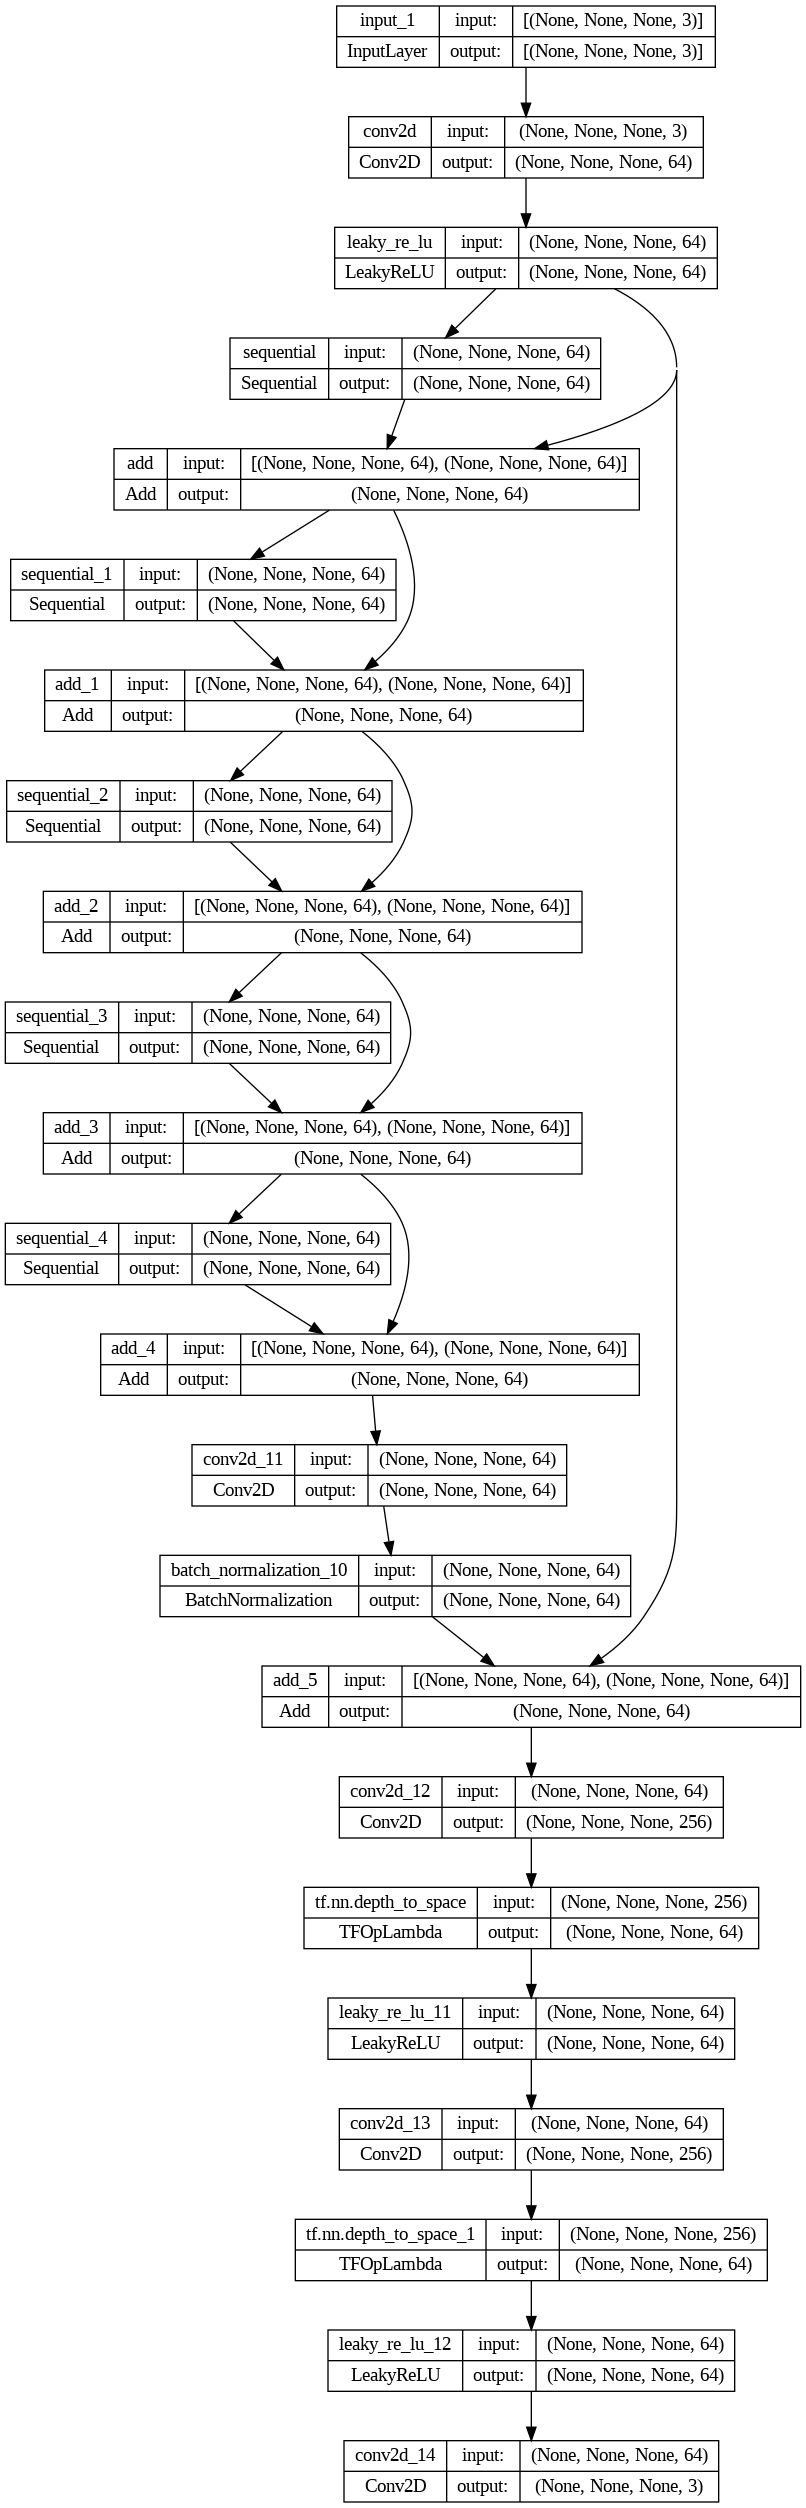

In [ ]:
tf.keras.utils.plot_model(SRResnet,show_shapes=True)

In [ ]:
def residual_block_disc(ch=64,k_s=3,st=1):
  model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
  ])
  return model

input_lr=tf.keras.layers.Input(shape=(128,128,3))
input_conv=tf.keras.layers.Conv2D(64,3,padding='same')(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

channel_nums=[64,128,128,256,256,512,512]
stride_sizes=[2,1,2,1,2,1,2]

disc=input_conv
for x in range(7):
  disc=residual_block_disc(ch=channel_nums[x],st=stride_sizes[x])(disc)

disc=tf.keras.layers.Flatten()(disc)

disc=tf.keras.layers.Dense(1024)(disc)
disc=tf.keras.layers.LeakyReLU()(disc)

disc_output=tf.keras.layers.Dense(1,activation='sigmoid')(disc)

discriminator=tf.keras.models.Model(input_lr,disc_output)

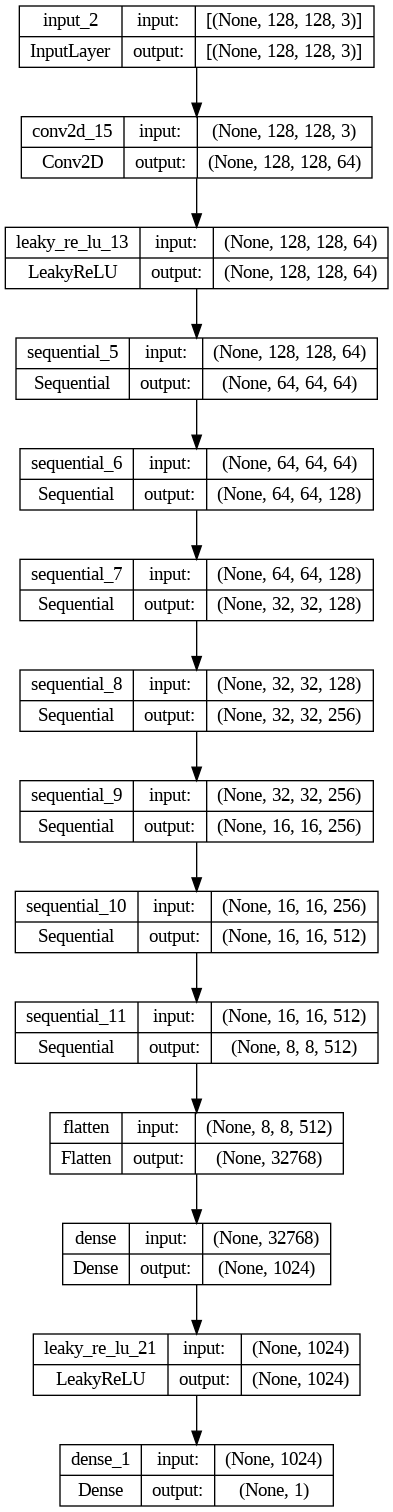

In [ ]:
tf.keras.utils.plot_model(discriminator,show_shapes=True)

In [ ]:
def PSNR(y_true,y_pred):
  mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
  return 20 * log10(1 / (mse ** 0.5))

def log10(x):
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

def pixel_MSE(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [ ]:
VGG19=tf.keras.applications.VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))
VGG19.layers

80134624/80134624 [==============================] - 1s 0us/step
